<a href="https://colab.research.google.com/github/ankurmahesh/ai4ess-hackathon-2020/blob/master/notebooks/seasonal_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI for Earth System Science Hackathon 2020: Seasonal Forecasting**

Ankur Mahesh (ClimateAi)

## Introduction


El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we will issue ENSO forecasts using machine learning, which uses statistical optimization to issue forecasts.






## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.
*   CNRM-CM5 pre-industrial control run climate model surface temperature
*   Max Planck Institute CMIP5 pre-industrial control run surface temperature

More information about the climate models can be found [here](https://esgf-node.llnl.gov/projects/cmip5/).

The pre-industrial control runs are climate model scenarios that assume that there are no anthropogenic emissions. The reason that we use the "pre-industrial control" run of the climate models as opposed to the historical runs is that the former runs are far longer, allowing us to have more data for neural network training.




### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

Throughout the hackathon, we will explore the effect of adding additional data, such as data from the CNRM-CM5 and MPI general circulation models.


### Test Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set: 

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).

In [4]:
#Download the required packages and the data that we will use 
#for this tutorial

!pip install netCDF4
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/CNRM_tas_anomalies_regridded.nc

     |████████████████████████████████| 4.1MB 3.5MB/s 
     |████████████████████████████████| 327kB 31.2MB/s 
--2020-06-21 18:31:31--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2020-06-21 18:31:31--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  47.3MB/s    in 9.1s    

2020

In [5]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


In [27]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


# Baseline Machine Learning Model


The baseline ML model will be linear regression.



RMSE: 0.28


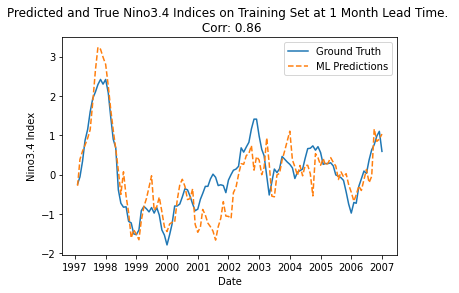

In [28]:

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Metrics

The metrics for evaluating an ML model are 

Pearson correlation, 

*  Pearson correlation
*   RMSE

The above code snippet includes examples of calculating them.

## Key Terms



Some terms:
*   predictor     : the input to a machine learning model: a certain number of months (that you define) of gridded temperature)
*   predictand    : the true value the model is trying to predict (i.e. the true Niño3.4 index)
*   prediction    : the output of the machine learning model



# Monday

##Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the target).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***Question***: In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




In the next code cell, let's study overfitting in the following task: training a machine learning model to forecast El Niño.  El Niño is a cycle of warm and cold temperatures in the equatorial Pacific Ocean that has broad implications for seasonal weather.

The code cell below demonstrates overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


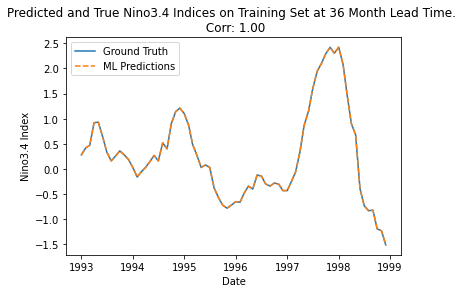

In [8]:
#Load in the predictors
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


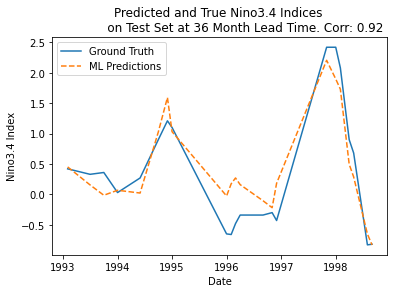

In [9]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

What happened above? Did we just develop a 36-month ahead forecast that has 0.81 correlation on unseen data??

Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**CODING EXERCISE** In the cell below, write code to evaluate the model on a true uncorrelated test set.

In [10]:
"""YOUR CODE HERE"""


'YOUR CODE HERE'

After your work on the previous exercise, check your understanding.  On a true test set, does the model making *36 month ahead* predictions generalize well?

***CODING EXERCISE*** Using the code samples above as a starting point, in the following cell, write code to calculate and plot the performance of the model at different lead times.

In [11]:
"""YOUR CODE HERE"""

'YOUR CODE HERE'

***CODING EXERCISE*** Calculate and plot the performance of the model with different size training datasets

In [12]:
"""YOUR CODE HERE"""

'YOUR CODE HERE'

## Monday: The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change? 

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Question*** 
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


Here's another example to help develop our visual understanding of bias vs. variance.

Here is how a k-Nearest-Neighbor model works:
1. The model is shown a sample data point from the test set, $x_\text{test}$
2. It searches its training set for the $k$ most similar data points
3. Of the $k$ points it founds, it calculates the most common predictand, and it assigns $x_\text{test}$ the most common 

Crucially, this method supports classification of data that is not linearly separable (see below image for an example)

***Polling question:*** For different values of $k$, would you expect a high bias/low variance classifier? Or a high variance/low bias classifier?

![alt text](https://cse3521.artifice.cc/images/effect-of-k.png)




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)
 
*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term: 

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above: 
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$: 
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Exercise*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset. 

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

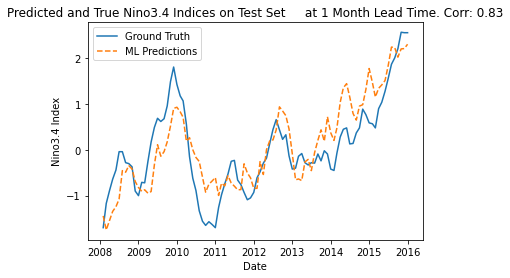

In [13]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


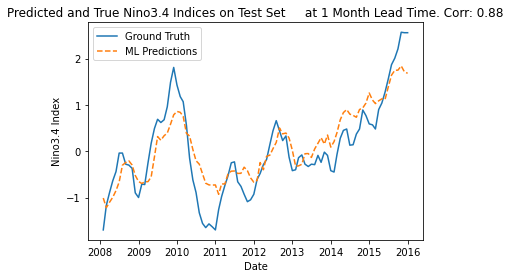

In [14]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


On the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

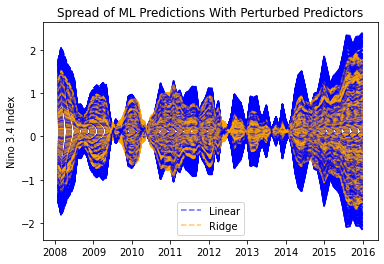

In [15]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)
  
  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

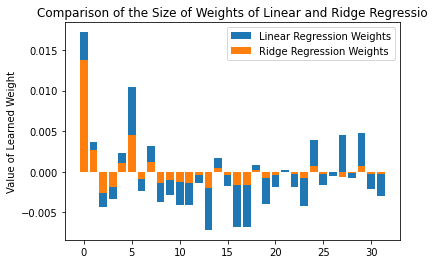

In [16]:
"""In this cell, we will visualize how the weights of the linear 
regression model are bigger than those of the ridge regression model"""

#coef_ loads in the coefficients from the trained model
regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regressio')
plt.show()

As expected, the weights of the ridge regression model are smaller than those of the linear regression model. 

There we have it! On our real-world ENSO dataset, we have confirmed our theoretical speculations about the effect of regularization on the bias-variance tradeoff!  

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting

## Machine Learning Models and Model Selection

### Variance Scaling

In the preprocessing presentation, we discussed ways that data is normalized before being fed into machine learning models.  Some models ML techniques require data to be centered (have mean 0); in other cases, normalization helps with numerical stability.  

One type of normalization is called variance scaling.  Variance scaling is to scale the variance of each predictor such that each predictor has a variance of 1.  

In our ENSO dataset, we have latxlon predictors; each predictor is temperature at a certain location on Earth.  We have ```num_time_steps``` samples of these predictors. Therefore, the shape of ```X``` is (num_time_steps, latxlon). *Variance scaling would mean that we scale our dataset such that the variance of temperature at each grid cell is 1.*

Should we use variance scaling for our ENSO forecasting model?

Acknowledgment: I'd like to  thank Professor [Patrick Brown](https://patricktbrown.org/about/) for helping me with this problem. 

In [17]:
"""Write code to explore the above question"""

'Write code to explore the above question'

# Tuesday

## Deep Learning

Now let's try training a neural network to forecast ENSO.  In this section, we will use PyTorch as our machine learning framework.



Let's get started: first, let's load the data.  **PLEASE READ THE DOCSTRING FOR THE `assemble_predictors_predictands` function!** It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In this section, the `assemble_predictors_predictands` method has been extended to load in data from observations AND from GCMs.

In [18]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date 
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an 
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each 
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use 
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  
  
  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)
    

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead, 
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**IMPORTANT info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


## Exercise 1: Train A Simple Convolutional Neural Network to Forecast ENSO


Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [19]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

**IMPORTANT** Reading through this method will help you understand each step in the process of training a neural network!

In [20]:
def train_network(net, criterion, optimizer, trainloader, testloader, 
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [21]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 01. loss: 0.479800
test Set: Epoch 01. loss: 0.260670
train Set: Epoch 02. loss: 0.172918
test Set: Epoch 02. loss: 0.162227
train Set: Epoch 03. loss: 0.111218
test Set: Epoch 03. loss: 0.184094
train Set: Epoch 04. loss: 0.125140
test Set: Epoch 04. loss: 0.439865
train Set: Epoch 05. loss: 0.143974
test Set: Epoch 05. loss: 0.423247
train Set: Epoch 06. loss: 0.141463
test Set: Epoch 06. loss: 0.159627
train Set: Epoch 07. loss: 0.182776
test Set: Epoch 07. loss: 0.171768
train Set: Epoch 08. loss: 0.086789
test Set: Epoch 08. loss: 0.214802
train Set: Epoch 09. loss: 0.071348
test Set: Epoch 09. loss: 0.185625
train Set: Epoch 10. loss: 0.083247
test Set: Epoch 10. loss: 0.265601
train Set: Epoch 11. loss: 0.076215
test Set: Epoch 11. loss: 0.304557
train Set: Epoch 12. loss: 0.061332
test Set: Epoch 12. loss: 0.153758
train Set: Epoch 13. loss: 0.072723
test Set: Epoch 13. loss: 0.160226
train Set: Epoch 14. loss: 0.054851
test Set: Epoch 14. loss: 0.153350
train 

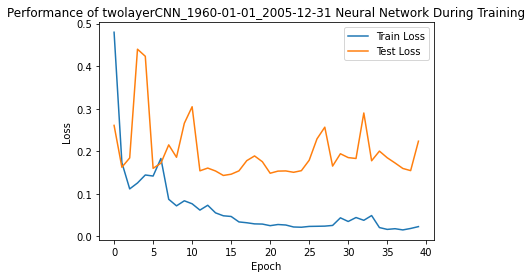

In [22]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Check your understanding:* From the previous section on fundamentals of machine learning, what is it called when the validation losses are very high and the train losses are very low?  What might we try to reduce this problem?

(Try reducing the number of parameters of the network -- see exercise 10!)

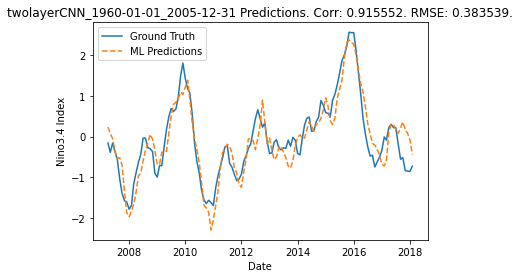

In [23]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

## Exercise 2: Forecast ENSO with Traditional Machine Learning using sklearn

Recall from the previous notebook that we used linear regression to forecast ENSO!  Try using other models for this task.  Explore the other models that sklearn has to offer, such as random forests!  Note: these traditional ML algorithms do not take advantage of the spatial nature of gridded datasets.  Therefore, they require the `data_format` argument to be set to 'flatten': the predictors are in the shape `(num_samples,lat*lon*num_time_steps)`.

**GOAL OF THIS EXERCISE:** try exploring the performance of other algorithms in the sklearn suite.  Try changing the lead_time in the `assemble_predictors_predictands` method (it is set to 1 initially).  How do the models perform?

In [ ]:
"""Plot the performance of linear regression at 1 month ahead lead time"""
#1 month linear regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

## Excercise 3: What data sources improve the ML algorithm? What data sources do not imprve the ML algorithm?

Let's try training our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset.  There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

**GOAL OF THIS EXERCISE**: generate two plots: one showing the time series of predicted and true Niño3.4 indices with an ML model trained on 1900-1930 data.  The other should show the same (time series of prediced and true Niño3.4 indices with a model trained on 1975-2005 data.  (Both trained algorithms should be tested on data from 2007-2018.)

In [4]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
  """YOUR CODE HERE"""
  #Replicate the logic in the Exercise 1 and Exercise 2 to explore 
  #how well a CNN or traditional ML model does with the start 
  #and end dates defined above!  Plot the performance of the models!

## Exercise 4: Data wrangling: Do machine learning algorithms perform better with a classification problem or regression problem?

Convert the problem from regression (predicting a continuous value) to classification (predicting a discrete value).  In this case, the continuous value is the exact value of the Niño3.4 index.  

Let's bin the Niño3.4 index to two values: 0 and 1.  Let's say negative values of the Niño3.4 index should be mapped to 0 and positive values of the index should be mapped to 1.

### Goal of the exercise:

Train a neural network and an sklearn logistic regression model to predict 0 or 1 corresponding to the mapping above!  Try changing the neural network's loss function from `nn.MSELoss` to `nn.BCEWithLogitsLoss`!

In [ ]:
#1.Adjust the train_network method so that the target is always 0 or 1. Maybe add an
# argument called "classification" that takes in a boolean value indicating
# whether or not to map the target to 0 or 1.
#2. Change the loss function of the neural network
#3. Run the train_network method to get the neural network predictions
#4. You will have to write your own code to calculate the accuracy of these predictions!

# Wednesday

## Exercise 5: GCMS!

In the deep learning for ENSO forecasting papers, the key breakthrough that allowed for state-of-the-art performance is that the algorithms were trained on general circulation models (GCMs).  The availability of observed data is very limited.  With simulated data, neural networks are able to see more data and thus learn better.

## Goal for this exercise:

Train a neural network on data from GCMs.  The MPI GCM has data from the years 1850 to .  The CNRM GCM has data from the years .  Does more data help?  Does the increase in data make it possible to train on longer lead times?

In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1860-01-01'
train_end_date = '2100-12-31'
num_input_time_steps = 4
lead_time = 5
climate_model = 'MPI'


train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, climate_model, 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name,
                  num_epochs=10)

## Exercise 6: Data Wrangling.  Should the predictors be the entire globe? Or just a specific region?

The Ham et. al. paper only uses Pacific temperatures to forecast the Niño3.4 index.  However, the Mahesh et. al. paper uses the entire globe.

Hypothesize which method you think might be better!  What assumptions does your hypothesis rely on?  Recall the bias-variance tradeoff that we discussed in the previous notebook!


*   Let's assume there is NO useful information for forecasting ENSO outside of the Pacific.  In other words, the rest of the world has no predictive power.  Would it make sense to use the entire globe as a predictor?  Discuss in the context of the bias-variance tradeoff.

The reality is probably mixed: the rest of the globe has some predictive power, but it also has noise!  Therefore, it's a tradeoff, because noisy inputs hurt model performance, but predictive inputs help performance!

#### GOAL OF THIS EXERCISE

Check out slicing xarray datasets by latitude and longitude at this [link](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html).

Fill in the code in the `assemble_predictors_predictands` method for the slicing!

In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(10, -10)
#Extract the following slice of longitude
lon_slice = slice(360-170,360-120)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

Now, let's do a sanity check.  Let's change `lat_slice` and `lon_slice` to random regions, where it is unlikely there is any ENSO signal.  Let's observe the performance of the model!

In [ ]:
#Aassemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(-50, 40)
#Extract the following slice of longitude
lon_slice = slice(0,100)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted (Using Nonsense Predictors) and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

#Thursday

#Excercise 7: Time Series of Gridded Monthly Temperature.  

Our inputs have so far have had 3 input months as each predictor, that is, `num_input_time_steps=3`.  Let's try changing this value and see how it affects the performance of our model!

**GOAL OF THIS EXERCISE:** Make a 2D matrix.  One axis denotes different values of `num_input_time_steps` . The other axis denotes different lead_times.  Plot the resulting matrix!

In [ ]:
for num_input_time_steps in range(1,7):
  for lead_time in range(1,5):
    experiment_name = "twolayerCNN_lead-{}_input-{}".format(num_input_time_steps, 
                                                            lead_time)
    """YOUR CODE HERE"""
    #Train and evaluate an ML algorithm of your choice on different
    #combinations of lead_time and num_input_time_steps.
    #Use plt.matshow to plot your results!

# Exercise 8: Get the best ENSO forecasting algorithm!  (Tip: check out ensembling between algorithms and try hyperparameter tuning.)

Do deeper neural networks with more convolutional layers help?
Try changing the hyperparameters of the neural network

*   learning rate
*   the choice of optimizer
*   the size of the convolution filters
*   the number of convolution filters
*   the number of weights in the fully connected layers

Does adding a time series of gridded monthly temperature as your predictor help?

Ensemble predictions from multiple different algorithms! Try using traditional ML, artificial neural networks, and convolutional neural networks.

Recall from the previous notebook: models with many parameters (i.e. very deep neural networks or very deep decision trees) are more likely to have very low bias and very high variance: they will likely overfit!


We will have a friendly competition.  *Develop a Nino3.4 Forecasting system for a lead_time of 5 months?* Submit your results to the kaggle link: https://www.kaggle.com/c/ams2020mlworkshop 

Details of the kaggle competition: just like in the first code cell, we will test our code on data from 2007-01-01 to 2017-12-31.  The data loader is reproduced below!  There are 131 predictor/predictand pairs between these dates.  Therefore, your entry should be exactly 131 numbers!  

## Ultimate Submission Code

In [ ]:
#Select the data parameters for your model(s)!
lead_time = 5
data_format = raise NotImplementedError("Select a data format for your kaggle entry!")
lat_slice = raise NotImplementedError("Select a lat slice for your kaggle entry!")
lon_slice = raise NotImplementedError("Select a lon slice for your kaggle entry!")
num_input_time_steps = 3 #Do not change this!
use_pca = raise NotImplementedError("You decide if you would like to use PCA on the input predictors!")
n_components = raise NotImplementedError("You decide how many principal components to use on the input predictors!")
train_predictors, train_predictands = """YOUR CODE HERE: assemble predictors predictands how you see fit"""

train_predictors, train_predictands = assemble_predictors_predictands('YOUR CHOICE OF START DATE',
                    'YOUR CHOICE OF END DATE', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)
#Do not change the line below for your kaggle submission
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)

#If using deep learning:
# create an ENSODataset and DataLoader
#object (see code cell in Exercise 1) and use the `train_network` method to 
#extract predictions!
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
cnn_predictions, _, _ = train_network()


#If using regular traditional ML with sklearn:
sklearn_model = #choose sklearn model
sklearn_model.fit(train_predictors,train_predictands)

sklearn_predictions = sklearn_model.predict(test_predictors)


#Ensemble predictions from multiple algorithms
#(i.e. take the average of predictions from multiple algorithms!)
predictions = (cnn_predictions +sklearn_predictions)/2.0



In [ ]:
#TO GENERATE A kaggle READY SUBMISSION:
import pandas as pd
submission_df = pd.DataFrame()
submission_df['Id'] = np.arange(130)
submission_df['Predicted'] = np.random.uniform(size=(130)) #replace with your predictions!
submission_df.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv') 

## Tip when changing convolutional layers:

When you are changing the size of convolution filter windows, pay special attention to the comment starting with "ATTENTION EXERCISE 9" in the `CNN` class.  This is a  TOUGH part of designing neural networks, especially in climate data where data is of many different grids!!  And it automatically causes your code to break!

After the convolution layers, ["features"](https://deepai.org/machine-learning-glossary-and-terms/feature-extraction) have been extracted from the input image.  These features are not necessarily of the same dimension as the input, but these features are spatial (that is, they are of the shape (batch_size, num_input_channels, lat, lon).  

We want to map these features to the value of the Niño3.4 index.  To do this mapping, we need a Linear (fully connected layer).  This Linear layer performs a matrix multiplication between the extracted features from the convolution layers and the weights of the linear layer.  Thus, it must know the dimensions of the features ahead of time.

The "Print" layer prints out the dimension of the extracted features.  Thus, we can design the linear layer accordingly, since the Linear layer requires the dimension of the input in order to perform a matrix multiplication.  

Of course, it is also possible and preferred to calculate the dimensions of the extracted features, using the formulas [here](http://cs231n.github.io/convolutional-networks/#conv).  Using the "Print" layer is a hacky get-around!

# EXERCISE 9: Do not just forecast ENSO.  Use this toolkit to forecast seasonal temperatures on land!

The machine learning framework we have developed here relies on assembling a set of predictors and predictands.  Thus far, the predictors have been surface temperature and the predictands have been the Nino3.4 index.  However, what if we wanted to forecast something else on seasonal time scales?  


In this section, please adjust the `assemble_predictors_predictands` methods to take into account ARBITRARY locations as predictors.  By default, the method uses the Nino3.4 Index.  Then, train a model to forecast temperature at regions you are interested in.

For the purpose of comparison, we will ask everyone to forecast temperature at these location at a lead time of 3 months:



*  Akron, Ohio: lat = 41, lon = 360-81
*  Mexico City, Mexico: lat = 19, lon = 360-99
*  Lima, Peru: lat = -12, 360-77


How does the forecasting performance change at these regions?

Feel free to test on any other regions you like and submit those as well.  We would love to the performance of your models at other regions as well.

In [6]:
"""Your CODE HERE"""

'Your CODE HERE'

#Practice EXERCISE 10: CNNs+LSTMs

If num_input_time_steps is greater than 1, then the model uses a time series of inputs to make its prediction.  Recurrent neural networks (with Long Short Term Memory (LSTM) architectures) are used for this purpose!  

**GOAL OF THIS EXERCISE:** Design a recurrent neural network (called an LSTM) for ENSO forecasting. For each input time step, 

1.   a CNN should extract features
2.   These features should then be fed into an LSTM

(The LSTM decides which parts of the features to remember and which to forget)

After the last input time step is fed into the LSTM, the model should use fully connected layers to make a forecast.

In [8]:
class CNNandLSTM(nn.Module):
  """YOUR CODE HERE"""

In [ ]:
class CNNandLSTM(nn.Module):
  """YOUR CODE HERE"""

# Practice Exercise 11: How does the quantity of data affect the performance of a machine learning algorithm?  

In the coding cell below, repeat the above training process for different length training datasets and test datasets!

**GOAL OF THIS EXERCISE**: train 6 neural networks: one on 10 years of data, one on 20 years of data, one on 30 years of data,...,one on 60 years of data.  Make a line plot showing the performance of each of these neural networks.  The X axis of the plot is the number of years of training data, and the y axis is the Pearson R value on the test set.

^Repeat the above for a traditional ML algorithm (e.g. linear regression) of your choice.

**Disclaimer:** this code cell involves training multiple neural networks.  I recommend working on this code cell after finishing the other parts of the hackathon.  Because of Google Colab [policy](https://research.google.com/colaboratory/faq.html), the availability of GPUs varies: sometimes, training multiple neural networks takes a liong time due to the availability of resources.

In [ ]:
for num_years in range(10,71,10):
  """YOUR CODE HERE"""
  pass